# Russel 2000 日足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

code = 'RUT'
symbol = '^%s' % code
#symbol = 'USDJPY=X'
ticker = yf.Ticker(symbol)
df = ticker.history(period='1y', interval='1d')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-04-01 00:00:00-04:00,2125.909912,2126.060059,2100.139893,2102.840088,3325930000,0.0,0.0
2024-04-02 00:00:00-04:00,2087.419922,2087.419922,2054.340088,2065.040039,3886590000,0.0,0.0
2024-04-03 00:00:00-04:00,2056.689941,2080.399902,2052.100098,2076.199951,3703250000,0.0,0.0
2024-04-04 00:00:00-04:00,2089.070068,2101.469971,2051.320068,2053.830078,4075680000,0.0,0.0
2024-04-05 00:00:00-04:00,2051.879883,2073.320068,2048.250000,2063.469971,3386780000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,2075.479980,2110.540039,2075.479980,2109.379883,4517990000,0.0,0.0
2025-03-25 00:00:00-04:00,2108.250000,2110.080078,2090.040039,2095.379883,4467340000,0.0,0.0
2025-03-26 00:00:00-04:00,2097.179932,2103.709961,2066.300049,2073.830078,4183140000,0.0,0.0


In [3]:
df0 = ticker.history(period='3y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-03-29 00:00:00-04:00,2079.310059,2138.449951,2079.310059,2133.100098,5085910000,0.0,0.0
2022-03-30 00:00:00-04:00,2132.830078,2132.830078,2084.370117,2091.070068,4385570000,0.0,0.0
2022-03-31 00:00:00-04:00,2090.909912,2100.739990,2069.219971,2070.129883,4823020000,0.0,0.0
2022-04-01 00:00:00-04:00,2071.219971,2091.729980,2068.050049,2091.110107,4562940000,0.0,0.0
2022-04-04 00:00:00-04:00,2091.530029,2096.929932,2076.500000,2095.439941,4547350000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,2075.479980,2110.540039,2075.479980,2109.379883,4517990000,0.0,0.0
2025-03-25 00:00:00-04:00,2108.250000,2110.080078,2090.040039,2095.379883,4467340000,0.0,0.0
2025-03-26 00:00:00-04:00,2097.179932,2103.709961,2066.300049,2073.830078,4183140000,0.0,0.0


## Moving Median

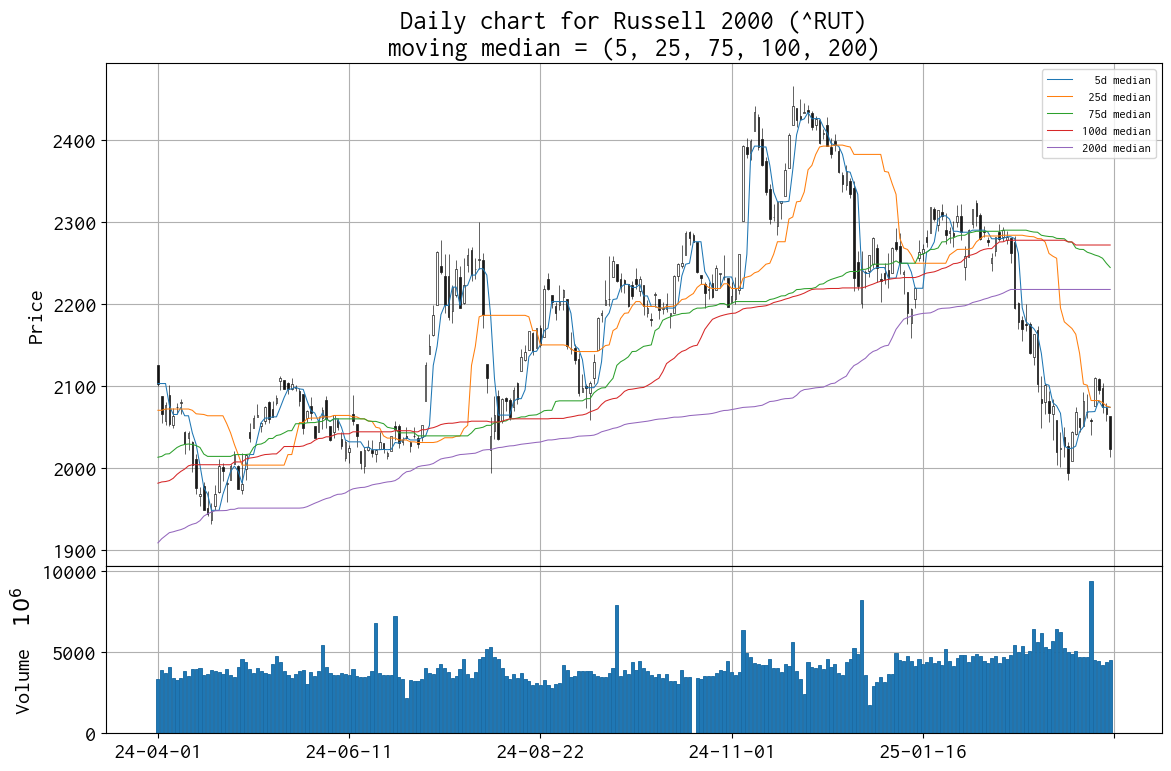

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

mm005 = df0['Close'].rolling(5).median()
mm025 = df0['Close'].rolling(25).median()
mm075 = df0['Close'].rolling(75).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm005[df.index], width=0.75, label='  5d median', ax=ax[0]),
    mpf.make_addplot(mm025[df.index], width=0.75, label=' 25d median', ax=ax[0]),
    mpf.make_addplot(mm075[df.index], width=0.75, label=' 75d median', ax=ax[0]),
    mpf.make_addplot(mm100[df.index], width=0.75, label='100d median', ax=ax[0]),
    mpf.make_addplot(mm200[df.index], width=0.75, label='200d median', ax=ax[0]),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=ax[1],
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
ax[0].set_title('Daily chart for %s (%s)\nmoving median = (5, 25, 75, 100, 200)' %(ticker.info['longName'], symbol))
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('report_daily_chart_median_%s.png' % code)
plt.show()

In [5]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-27 00:00:00-04:00,2072.479980,2079.300049,2057.600098,2065.699951,4403460000,0.0,0.0
2025-03-28 00:00:00-04:00,2063.310059,2063.310059,2013.000000,2023.270020,4513330000,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-03-27 00:00:00-04:00    2065.699951
2025-03-28 00:00:00-04:00    2023.270020
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-03-27 00:00:00-04:00          NaN
2025-03-28 00:00:00-04:00   -42.429932
Name: Close, dtype: float64

In [8]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-03-28 00:00:00-04:00   -40.040039
dtype: float64

In [9]:
df['Close'].rolling(9).median().tail()

Date
2025-03-24 00:00:00-04:00    2056.979980
2025-03-25 00:00:00-04:00    2068.330078
2025-03-26 00:00:00-04:00    2068.629883
2025-03-27 00:00:00-04:00    2068.629883
2025-03-28 00:00:00-04:00    2068.629883
Name: Close, dtype: float64

In [10]:
df['Close'].rolling(13).median().tail()

Date
2025-03-24 00:00:00-04:00    2056.979980
2025-03-25 00:00:00-04:00    2056.979980
2025-03-26 00:00:00-04:00    2056.979980
2025-03-27 00:00:00-04:00    2065.699951
2025-03-28 00:00:00-04:00    2065.699951
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(26).median().tail()

Date
2025-03-24 00:00:00-04:00    2091.415039
2025-03-25 00:00:00-04:00    2088.729980
2025-03-26 00:00:00-04:00    2080.805054
2025-03-27 00:00:00-04:00    2077.505005
2025-03-28 00:00:00-04:00    2074.655029
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(52).median().tail()

Date
2025-03-24 00:00:00-04:00    2244.380005
2025-03-25 00:00:00-04:00    2229.099976
2025-03-26 00:00:00-04:00    2207.295044
2025-03-27 00:00:00-04:00    2207.295044
2025-03-28 00:00:00-04:00    2207.295044
Name: Close, dtype: float64

## Robust Bollinger's bands

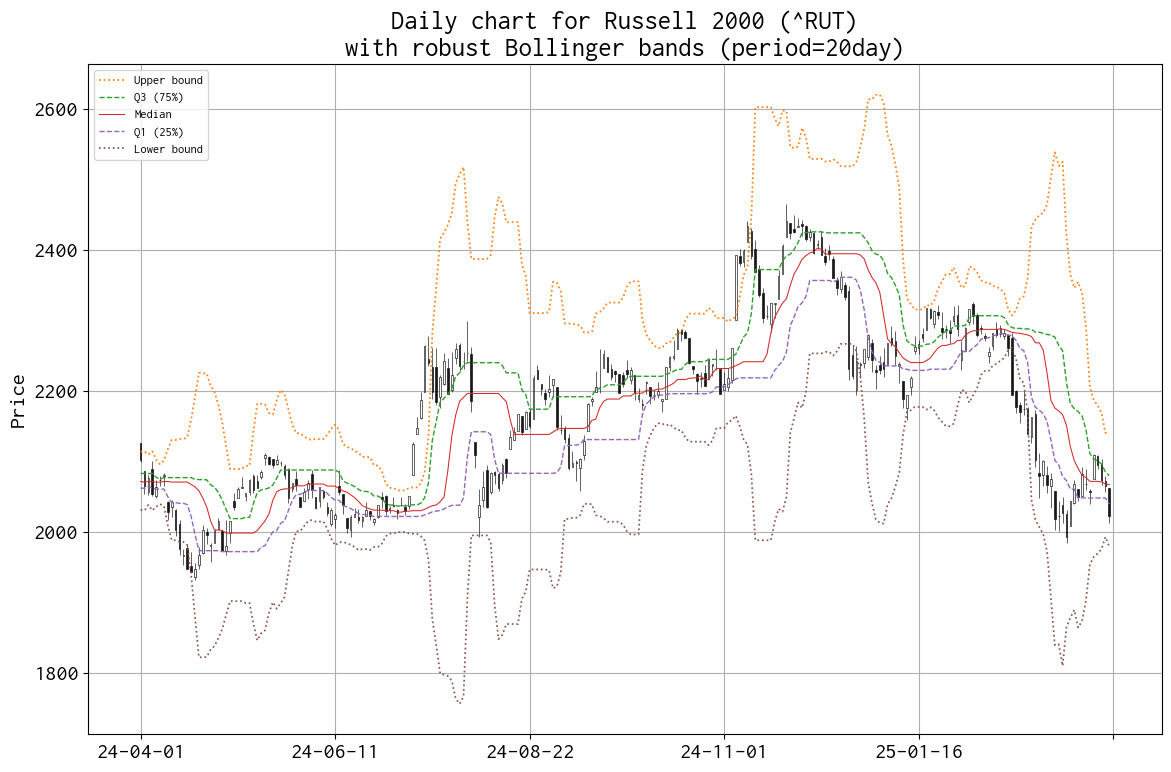

In [13]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 20
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    addplot=apds,
    datetime_format='%y-%m-%d',
    xrotation=0,
    ax=ax,
)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dday)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%dday)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

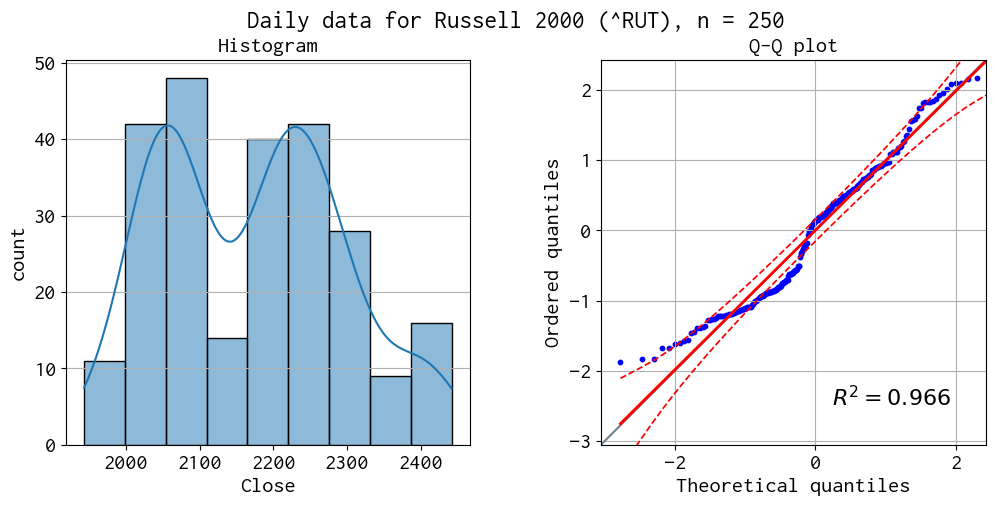

In [14]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()